# 导入依赖库

In [1]:
import json
import pandas as pd
from utils import backtest, plot_cumulative_returns
from strats import BaseStrategy


# 参数配置

In [2]:
train_start = '2025-02-01'          # 训练集起始日期
train_end = '2025-04-30'            # 训练集起始日期
valid_start = '2025-05-01'          # 验证集起始日期
valid_end = '2025-05-31'            # 验证集起始日期
reb_dict_path = 'data/reb_dict.json'  # 调仓字典路径


# 策略

In [3]:
class ETFWeekly(BaseStrategy):
    params = (
        ('selection_dict', {}),
    )

    def __init__(self):
        self.sel = self.p.selection_dict

    def next(self):
        dt = self.datas[0].datetime.date(0).strftime('%Y-%m-%d')
        if dt in self.sel:
            reb_dict = self.sel[dt]
            selected = list(reb_dict.keys())

            # 平掉未被选中的持仓ETF
            for d in self.datas:
                if d._name not in selected and self.getposition(d).size:
                    self.close(d)

            # 建仓或调仓被选中的ETF
            for code in selected:
                target_pct = 0.99 * reb_dict[code]
                d = self.getdatabyname(code)
                self.order_target_percent(d, target=target_pct)


# 回测

In [4]:
# 获取调仓字典
with open(reb_dict_path, 'r') as f:
    reb_dict = json.load(f)


In [5]:
# 训练集
train_strat_return, train_bench_return = backtest(
    ETFWeekly, selection_dict=reb_dict, start_date=train_start, end_date=train_end, printlog=False
)


基准收益率: -0.54%
收益率: 12.33%
年化收益率: 67.88%
最大回撤: 5.63%
交易次数: 49
胜率: 61.36%


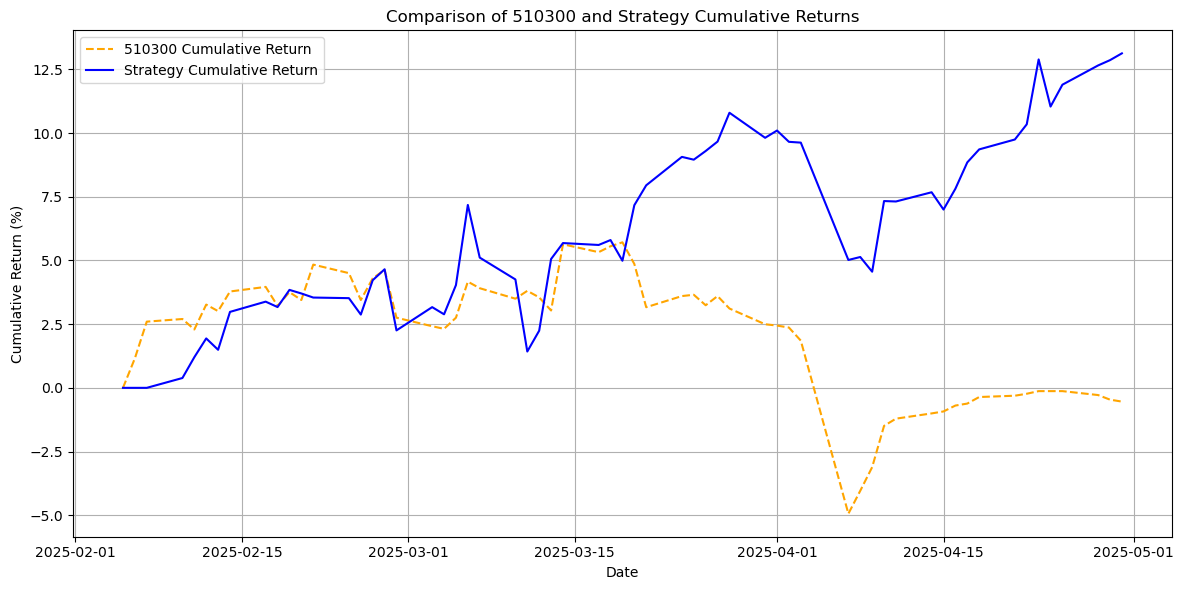

In [6]:
plot_cumulative_returns(train_strat_return)

In [7]:
# 验证集
valid_strat_return, valid_bench_return = backtest(
    ETFWeekly, selection_dict=reb_dict, start_date=valid_start, end_date=valid_end, printlog=False
)


基准收益率: 1.43%
收益率: 5.09%
年化收益率: 96.43%
最大回撤: 2.80%
交易次数: 11
胜率: 83.33%


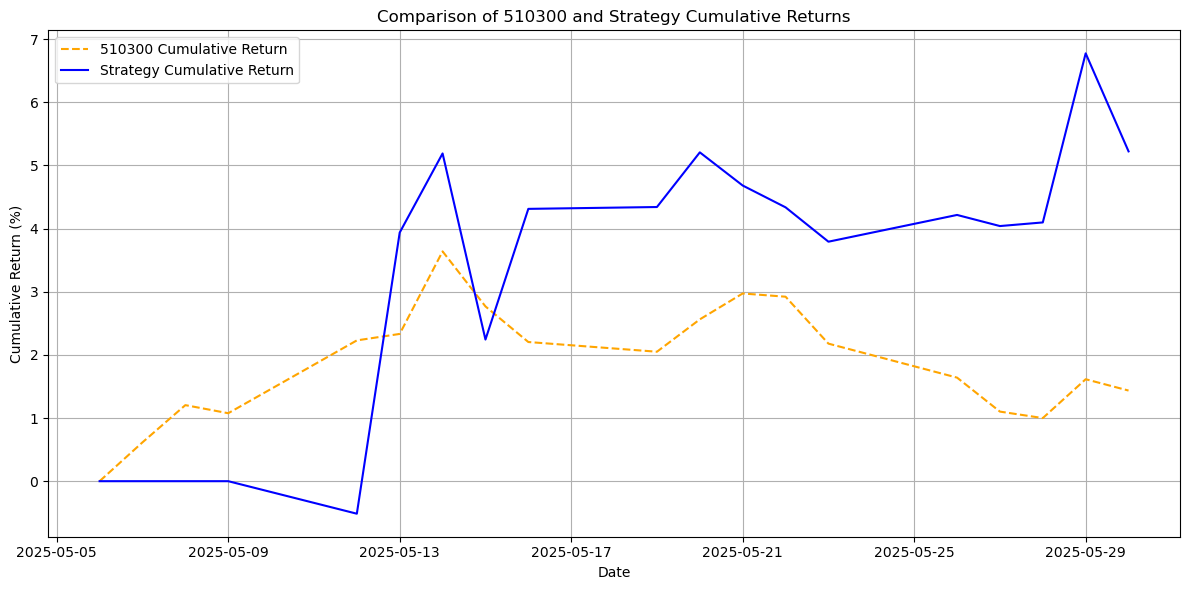

In [8]:
plot_cumulative_returns(valid_strat_return)